In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip install tf2cv tensorflow>=2.0.0

In [0]:
from tensorflow.python.client import device_lib
dev=device_lib.list_local_devices()
dev[len(dev)-1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 134500487591764942
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [0]:
#global consts
IMG_SIZE='137x236'
HEIGHT = 137
WIDTH = 236
BATCH_SIZE=128
DROP_OUT=0.0
FOLD=0
TRAIN_DIR = './train/'
TRAIN_IMG_DIR=TRAIN_DIR+str(IMG_SIZE)
EPOCHS = 200
STATS_FS = (0.055029564364430086, 0.17228061284674265)
STATS_128 = (0.0692, 0.2051)
EXPERIMENT='sernext_3cmc_fullsize_OHEM'
INPUT_DIR ='/content/drive/My Drive/kaggle/bengali/input/'
OUTPUT_DIR = '/content/drive/My Drive/kaggle/bengali/output/'
IMPORT_DIR = '/content/drive/My Drive/kaggle/bengali/nbs/'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'
CHKP_DIR = EXPERIMENT_DIR+'chkp/'
OUTPUT_SUBDIR = ''
DATASET_224='224x224-bengali.zip'
DATASET_128='grapheme-imgs-128x128.zip'
DATASET_FS = 'bengali-full-size.zip'
TRAIN_WITH_FOLD = 'train_with_fold_20.csv'
TRAIN_WITH_FOLD_5 = 'train_with_fold.csv'
PRETRAINED = True
PRETRAINED_WEIGHTS = 'w_r_0.98565.h5'
LOG_FILE = EXPERIMENT_DIR+'log_'+EXPERIMENT+'.csv'
#INITIAL_EPOCH=40
#HEAD_WD=1e-3
#BACKBONE_WD = 1e-4

if IMG_SIZE == 128: DATASET=DATASET_128
if IMG_SIZE == 224: DATASET=DATASET_224
if IMG_SIZE == '137x236' : DATASET=DATASET_FS


#lr sheduler consts
LR_MAX = 0.001
LR_MIN = 0.00001
T_MAX = 100

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append(IMPORT_DIR+'py/models/')
sys.path.append(IMPORT_DIR+'py/utils/')
sys.path.append(IMPORT_DIR+'py/callbacks/')
sys.path.append(IMPORT_DIR+'py/opts/')

In [0]:
#import local modules
#from mish import Mish,mish
from generators import *
from kaggle_metric import *
from cosine import CosineAnnealingScheduler
from kagglevalidation import KaggleValidationFS
#from lookahead import Lookahead
from se_resnext50 import build_se_resnext50_model_fs_wod
#from md121v2 import build_md121_v2_model
#from losses import categorical_focal_loss


#import external modules
import numpy as np 
import pandas as pd 

import os
import errno

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight

In [0]:
try:
  os.mkdir(TRAIN_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_DIR+' already exists')
    else:
        raise
try:
  os.mkdir(TRAIN_IMG_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_IMG_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(EXPERIMENT_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(EXPERIMENT_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(CHKP_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(CHKP_DIR+' already exists')
    else:
        raise


os.system('cp '+ '"'+INPUT_DIR+DATASET+'" ' + TRAIN_DIR)
os.system('cp '+ '"'+INPUT_DIR+TRAIN_WITH_FOLD+'" ' + TRAIN_DIR)

/content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_OHEM/ already exists
/content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_OHEM/chkp/ already exists


0

In [0]:
os.system('cp '+ '"'+INPUT_DIR+TRAIN_WITH_FOLD_5+'" ' + TRAIN_DIR)

0

In [0]:
if PRETRAINED: os.system('cp '+ '"'+EXPERIMENT_DIR+PRETRAINED_WEIGHTS+'" '+TRAIN_DIR)

In [0]:
os.system('unzip -q '+TRAIN_DIR+DATASET+ ' -d '+ TRAIN_IMG_DIR)

0

In [0]:
!ls train

137x236		       train_with_fold_20.csv  w_r_0.98565.h5
bengali-full-size.zip  train_with_fold.csv


In [0]:
dataset_np = pd.read_csv(TRAIN_DIR+TRAIN_WITH_FOLD_5).to_numpy()
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]


valid_m = np.where(dataset_np[:,6]==FOLD)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != FOLD)
fold_valid_inds = np.where(dataset_np[:,6] == FOLD)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]

train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [0]:
model =  build_se_resnext50_model_fs_wod(height=HEIGHT, width=WIDTH)

In [0]:
cutout_datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(p=0.5,s_l=0.15,s_h=0.25,r_1=0.8,r_2=1.2,v_l=0,v_h=0))

mcm_datagen = ImageDataGenerator()

In [0]:
columns=["root_class","vowel_class", "cons_class"]

mcm_generator1 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

mcm_generator2 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")


cutout_generator = cutout_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

Found 160672 validated image filenames.
Found 160672 validated image filenames.
Found 160672 validated image filenames.


In [0]:
def mine_hard_datagen_cutout(datagen,model,batch_size=BATCH_SIZE, st=STATS_FS):
  while True:
       samples, targets_root, targets_vowel, targets_cons = [], [], [], []
       #print('mining start')
       while len(samples) < batch_size:
           x_data, y_data = prep_batch_fs_shuffled(next(datagen),st=st)
           preds = model.predict(x_data)
           errors = np.abs(preds[0] - y_data[0]).max(axis=-1) > 0.2
           samples += x_data[errors].tolist()
           targets_root  += y_data[0][errors].tolist()
           targets_vowel += y_data[1][errors].tolist()
           targets_cons  += y_data[2][errors].tolist()

       #print('mining stoped')

       regular_samples = batch_size * 2 - len(samples)
       x_data, y_data = prep_batch_fs_shuffled(next(datagen),st=st)
       samples += x_data[:regular_samples].tolist()
       targets_root +=  y_data[0][:regular_samples].tolist()
       targets_vowel += y_data[1][:regular_samples].tolist()
       targets_cons +=  y_data[2][:regular_samples].tolist()

       samples, targets_root,targets_vowel, targets_cons = map(np.array, (samples, targets_root,targets_vowel, targets_cons))


       idx = np.arange(batch_size * 2)
       np.random.shuffle(idx)
       batch1, batch2 = np.split(idx, 2)
       yield samples[batch1], [targets_root[batch1], targets_vowel[batch1], targets_cons[batch1]]
       yield samples[batch2], [targets_root[batch2], targets_vowel[batch2], targets_cons[batch2]]

In [0]:
def mine_hard_datagen_mixup(datagen1,datagen2,model,batch_size=BATCH_SIZE, alpha=0.4, st=STATS_FS):
  while True:
       samples, targets_root, targets_vowel, targets_cons = [], [], [], []
       #print('mining start')
       while len(samples) < batch_size:
           batch1 = next(datagen1)
           batch2 = next(datagen2)
           x_data,y_data = mix_batches_fs_shuffled(batch1,batch2,alpha=alpha,st=st)
           #x_data, y_data = prep_batch_fs_shuffled(next(datagen),st=st)
           preds = model.predict(x_data)
           errors = np.abs(preds[0] - y_data[0]).max(axis=-1) > 0.2
           samples += x_data[errors].tolist()
           targets_root  += y_data[0][errors].tolist()
           targets_vowel += y_data[1][errors].tolist()
           targets_cons  += y_data[2][errors].tolist()

       #print('mining stoped')

       regular_samples = batch_size * 2 - len(samples)
       batch1 = next(datagen1)
       batch2 = next(datagen2)
       x_data, y_data = mix_batches_fs_shuffled(batch1,batch2,alpha=alpha,st=st)
       samples += x_data[:regular_samples].tolist()
       targets_root +=  y_data[0][:regular_samples].tolist()
       targets_vowel += y_data[1][:regular_samples].tolist()
       targets_cons +=  y_data[2][:regular_samples].tolist()

       samples, targets_root,targets_vowel, targets_cons = map(np.array, (samples, targets_root,targets_vowel, targets_cons))


       idx = np.arange(batch_size * 2)
       np.random.shuffle(idx)
       batch1, batch2 = np.split(idx, 2)
       yield samples[batch1], [targets_root[batch1], targets_vowel[batch1], targets_cons[batch1]]
       yield samples[batch2], [targets_root[batch2], targets_vowel[batch2], targets_cons[batch2]]

In [0]:
def mine_hard_datagen_cutmix(datagen1,datagen2,model,batch_size=BATCH_SIZE, alpha=1.0, st=STATS_FS):
  while True:
       samples, targets_root, targets_vowel, targets_cons = [], [], [], []
       #print('mining start')
       while len(samples) < batch_size:
           batch1 = next(datagen1)
           batch2 = next(datagen2)
           x_data,y_data = cutmix_batches_fs2_shuffled(batch1,batch2,alpha=alpha,st=st)
           #x_data, y_data = prep_batch_fs_shuffled(next(datagen),st=st)
           preds = model.predict(x_data)
           errors = np.abs(preds[0] - y_data[0]).max(axis=-1) > 0.2
           samples += x_data[errors].tolist()
           targets_root  += y_data[0][errors].tolist()
           targets_vowel += y_data[1][errors].tolist()
           targets_cons  += y_data[2][errors].tolist()

       #print('mining stoped')

       regular_samples = batch_size * 2 - len(samples)
       batch1 = next(datagen1)
       batch2 = next(datagen2)
       x_data, y_data = cutmix_batches_fs2_shuffled(batch1,batch2,alpha=alpha,st=st)
       samples += x_data[:regular_samples].tolist()
       targets_root +=  y_data[0][:regular_samples].tolist()
       targets_vowel += y_data[1][:regular_samples].tolist()
       targets_cons +=  y_data[2][:regular_samples].tolist()

       samples, targets_root,targets_vowel, targets_cons = map(np.array, (samples, targets_root,targets_vowel, targets_cons))


       idx = np.arange(batch_size * 2)
       np.random.shuffle(idx)
       batch1, batch2 = np.split(idx, 2)
       yield samples[batch1], [targets_root[batch1], targets_vowel[batch1], targets_cons[batch1]]
       yield samples[batch2], [targets_root[batch2], targets_vowel[batch2], targets_cons[batch2]]

In [0]:
def g3_ohem_generator(mixup_hard_gen,cutmix_hard_gen, cutout_hard_gen):
    while True:
        p = np.random.rand()
        if p>0.8:
            x_res,y_res = next(cutout_hard_gen)
        else:
            q = np.random.rand()
            if q>0.3:
                x_res,y_res = next(mixup_hard_gen)
            else:
                x_res,y_res = next(cutmix_hard_gen)
        yield x_res,y_res

In [0]:
def g3_generator_fs2(gen1,gen2, gen3,h=HEIGHT,w=WIDTH,st=STATS_FS):
    while True:
        p = np.random.rand()
        if p>1:
            batch = next(gen3)
            x_res,y_res = prep_batch_fs_shuffled(batch,st=st)
        else:
            batch1 = next(gen1)
            batch2 = next(gen2)
            q = np.random.rand()
            if q>0:
                x_res,y_res = mix_batches_fs_shuffled(batch1,batch2,alpha=0.1,st=st)
            else:
                x_res,y_res = cutmix_batches_fs2_shuffled(batch1,batch2,alpha=1.0,h=h,w=w,st=st)
        yield x_res,y_res

In [0]:
cutout_hard_generator = mine_hard_datagen_cutout(cutout_generator,model,batch_size=BATCH_SIZE, st=STATS_FS)
mixup_hard_generator  = mine_hard_datagen_mixup(mcm_generator1,mcm_generator2,model,batch_size=BATCH_SIZE,alpha=0.1,st=STATS_FS)
cutmix_hard_generator = mine_hard_datagen_cutmix(mcm_generator1,mcm_generator2,model,batch_size=BATCH_SIZE,alpha=0.8,st=STATS_FS)
g3_ohem_datagen=g3_ohem_generator(mixup_hard_generator,cutmix_hard_generator,cutout_hard_generator)

NameError: ignored

In [0]:
g3_datagen = g3_generator_fs2(mcm_generator1,mcm_generator2,cutout_generator)

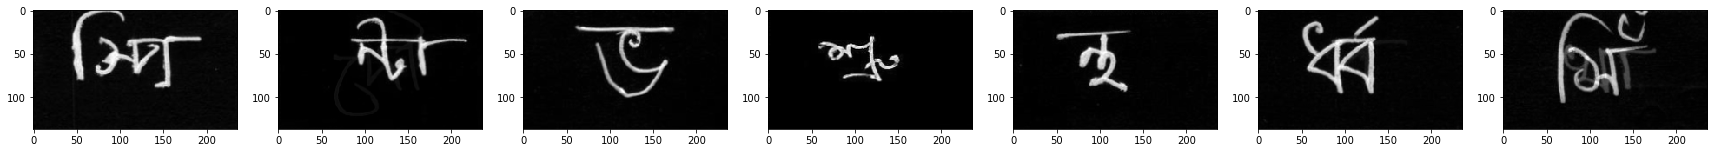

In [0]:
if 1: 
  batch_x,y = next(g3_datagen)
  import matplotlib.pyplot as plt
  fig, axs = plt.subplots(1, 7, figsize=(30, 30))
  for i in range(7):
    axs[i].imshow(batch_x[i,:,:,0], cmap='gray')
  plt.show()

In [0]:
opt=tf.keras.optimizers.Adam(learning_rate=LR_MAX)

In [0]:
checkpoint =  tf.train.Checkpoint(latest_epoch=tf.Variable(0), optimizer=opt, model=model)
chkp_manager =  tf.train.CheckpointManager(checkpoint, CHKP_DIR, max_to_keep=3)

In [0]:
chkp_manager.latest_checkpoint

'/content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_OHEM/chkp/ckpt-63'

In [0]:
chkp_restore_status=checkpoint.restore(chkp_manager.latest_checkpoint)
if chkp_manager.latest_checkpoint:
  #chkp_restore_status.assert_consumed()
  print("Restored from {}".format(chkp_manager.latest_checkpoint))
  print(f"Lastest epoch {checkpoint.latest_epoch.numpy()}")
else:
  print("Initializing from scratch.")

Restored from /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_OHEM/chkp/ckpt-63
Lastest epoch 63


In [0]:
if PRETRAINED: model.load_weights(TRAIN_DIR+PRETRAINED_WEIGHTS)

In [0]:
from tensorflow.keras.callbacks import Callback
class GetCurrentOHEMThreshold(Callback):

    def __init__(self, current_ohem_threhold,first_threshold=0.1,last_threshold=0.2, num_epochs=50.0):
        super(GetCurrentOHEMThreshold, self).__init__()
        self.current_ohem_threshold = current_ohem_threhold
        self.first_threshold = first_threshold
        self.last_threshold = last_threshold
        self.num_epochs=num_epochs


    def on_epoch_begin(self, epoch, logs=None):
        new_threshold = self.first_threshold + epoch*(self.last_threshold-self.first_threshold)/self.num_epochs
        print(f'set ohem threshold:{new_threshold}')
        # Set new value
        tf.keras.backend.set_value(self.current_ohem_threshold, new_threshold)

In [0]:
def ohem_loss(current_threshold):

    def loss(ytrue,ypred):
      result = tf.keras.backend.categorical_crossentropy(ytrue, ypred, axis=-1)
      index =  tf.keras.backend.greater(result, current_threshold)
      cast = tf.cast(index, tf.float32)
      return result*cast
    
    return loss

In [0]:
current_threshold =  tf.keras.backend.variable(0.0)

In [0]:
loss_dict={'root':    ohem_loss(current_threshold=current_threshold),
           'vowel':   ohem_loss(current_threshold=current_threshold),
           'consonant':ohem_loss(current_threshold=current_threshold)}
model.compile(optimizer=opt, loss=loss_dict, loss_weights=[4.0,1.0,1.0])

In [0]:
initial_epoch = checkpoint.latest_epoch.numpy()

print(f'epochs trained: {initial_epoch}. start training epoch {initial_epoch+1}...')
ca_shed = CosineAnnealingScheduler(T_max=50, eta_max=0.0001, eta_min=0.00001,verbose=1, initial_epoch=0)
#rolrplt = tf.keras.callbacks.ReduceLROnPlateau(monitor='kaggle',mode='max', patience=5, verbose=1, factor=0.5, min_lr=LR_MIN)

get_ct =  GetCurrentOHEMThreshold(current_threshold)


suffix =EXPERIMENT+\
                '_eps'+str(EPOCHS)+\
                '_iniep'+str(initial_epoch)+\
                '_sz'+str(IMG_SIZE)+\
                '_bs'+str(BATCH_SIZE)+\
                '_do'+str(DROP_OUT)+\
                '_'+model.optimizer.get_config()['name']+\
                '_IS_fold'+str(FOLD)


kv = KaggleValidationFS(valid_df,
                      batch_size=512,
                      vals_per_epoch=1,
                      train_steps=train_m//BATCH_SIZE+1,
                      logfile=EXPERIMENT_DIR+'log_kr_'+suffix+'.csv',
                      initial_epoch=initial_epoch,
                      suffix = suffix,
                      train_img_dir=TRAIN_IMG_DIR,
                      output_dir=EXPERIMENT_DIR,
                      thresholds=[0.985,0.992,0.990],
                      chkp_manager=chkp_manager,
                      in_shape=[HEIGHT,WIDTH],
                      st=STATS_FS)

#tf.keras.backend.set_value(model.optimizer.lr, 0.0001)
cbs = [kv,get_ct,ca_shed]

history=model.fit(g3_datagen,
                  epochs=EPOCHS,
                  steps_per_epoch=train_m//BATCH_SIZE+1,
                  callbacks=cbs,
                  verbose=1)

epochs trained: 125. start training epoch 126...
Train for 1256 steps
set ohem threshold:0.1

Epoch 00001: CosineAnnealingScheduler setting learning rate to 0.0001.
Epoch 1/200
1255/1256 [============================>.] - ETA: 0s - loss: 1.1037 - root_loss: 0.2147 - vowel_loss: 0.1497 - consonant_loss: 0.0954
batch 1255: validation...



[0:21:44] - kaggle:0.9657 - root:0.9526 -vowel:0.9828 - cons: 0.9747

saved checkpoint for epoch 126: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_OHEM/chkp/ckpt-126

1256/1256 [==============================] - 1307s 1s/step - loss: 1.1037 - root_loss: 0.2146 - vowel_loss: 0.1497 - consonant_loss: 0.0954
set ohem threshold:0.10200000000000001

Epoch 00002: CosineAnnealingScheduler setting learning rate to 9.991120277927223e-05.
Epoch 2/200
1255/1256 [============================>.] - ETA: 0s - loss: 1.0974 - root_loss: 0.2132 - vowel_loss: 0.1500 - consonant_loss: 0.0945
batch 1255: validation...



[0:43:03] - kaggle:0.9660 - root:0.9527 -vowel:0.9826 - cons: 0.9761

saved checkpoint for epoch 127: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_OHEM/chkp/ckpt-127

1256/1256 [==============================] - 1279s 1s/step - loss: 1.0973 - root_loss: 0.2132 - vowel_loss: 0.1500 - consonant_loss: 0.0945


In [0]:
model.optimizer.get_config()